In [2]:
import sys
if "../../" not in sys.path: sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import os
from os import path
from scipy import stats, signal, ndimage
from tqdm.notebook import tqdm
import math
import time
import pickle
import glob
import random

import seaborn as sns
from matplotlib.lines import Line2D

from analysis.analysis_helpers import load_data, savefig, load_data_by_session_id, heatmap_log_proba_plot
from analysis.eye_plotting import STIM_ABBREV, STIM_COLORS, STIM_ORDERING
from experiment.cre_line import match_cre_line, CRE_COLORS, CRE_ORDERING
from eye_tracking.eye_tracking import get_saccade_magnitude_direction, get_stim_at_frame

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
df = pd.DataFrame(columns=["session_id", "specimen_name", "genotype"])

for data in load_data(desc="Loading sessions"):
    sdata = data["session_data"]

    if "C" in sdata["session_type"]:
        stim_epoch = data["stim_epoch"]
        n_spont = len(stim_epoch[stim_epoch["stimulus"] == "spontaneous"])

        if n_spont != 2:
            print("WARN", sdata["session_id"], "has", n_spont, "spontaneous epochs")
            print(stim_epoch)
            continue

        metadata = data["metadata"]
        genotype = metadata["genotype"]
        sid = sdata["session_id"]
        specimen_name = metadata["specimen_name"]

        df.loc[len(df)] = (sid, specimen_name, genotype)

In [34]:
"""
Filter used to smooth the running speed trace.
"""
def smooth_run_speed(data, method="gaussian"):
    if method == "savgol":
        return signal.savgol_filter(data, 51, 3)
    elif method == "gaussian":
        return ndimage.filters.gaussian_filter1d(data, 10)
    else:
        return None

In [23]:
df["genotype"].value_counts()

Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                         41
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                    29
Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                              22
Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                             21
Nr5a1-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                                 20
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                    19
Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                            19
Pvalb-IRES-Cre/wt;Ai162(TIT2L-GC6s-ICL-tTA2)/wt                                  13
Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)    13
Ntsr1-Cre_GN220/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                 11
Fezf2-CreER/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                      9
Rorb-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                       

Using specifically `Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt` mice, look at the individual mouse variability in running speed during spontaneous epochs.

In [49]:
data["eye_tracking"]

,frame,eye_area,pupil_area,x_pos_deg,y_pos_deg,speed_x,speed_y,speed
frame,,,,,,,,
0,0,0.057137,0.006448,-9.686957,11.569533,NaN,NaN,NaN
1,1,0.056497,0.006403,-9.488208,11.737089,-0.004123,-0.779361,0.779372
2,2,0.056677,0.006446,-9.687232,11.517576,-5.602812,1.401939,5.775547
3,3,0.057546,0.006393,-9.861729,11.830552,-1.856169,5.062510,5.392065
4,4,0.057274,0.006491,-9.810976,11.855077,0.768893,-5.214281,5.270666
...,...,...,...,...,...,...,...,...
127855,127855,0.055339,0.002519,-8.062725,9.556998,-0.879086,-1.371922,1.629406
127856,127856,0.055459,0.002588,-8.045692,9.597478,-1.945948,0.170851,1.953434
127857,127857,0.055620,0.002522,-8.192455,9.568388,2.389258,-0.029330,2.389438


In [50]:
stim_metrics = pd.DataFrame(columns=["specimen_name", "genotype", "session_id", "stimulus", "duration_sec", "mean_run", "fraction_running", "mean_pupil"])
RUN_THRESHOLD = 1

for data in load_data(desc="Loading stimulus data"):
    specimen_name = data["metadata"]["specimen_name"]
    genotype = data["metadata"]["genotype"]
    sid = data["session_data"]["session_id"]
    run = data["running_speed"]
    run = smooth_run_speed(run)
    pupil = data["eye_tracking"]["pupil_area"]
    
    for _, row in data["stim_epoch"].iterrows():
        stim = row["stimulus"]
        start, end = row["start"], row["end"]
        dur_sec = (end - start) / 30
        run_trace = run[start:end]
        mean_run = run_trace.mean()
        frac_run = np.mean(np.abs(run_trace) > RUN_THRESHOLD)
        mean_pupil = pupil[start:end].mean() * 100 # convert from cm^2 to mm^2

        stim_metrics.loc[len(stim_metrics)] = (specimen_name, genotype, sid, stim, dur_sec, mean_run, frac_run, mean_pupil)

In [51]:
np.random.permutation(10)

array([8, 2, 0, 3, 9, 1, 5, 6, 4, 7])

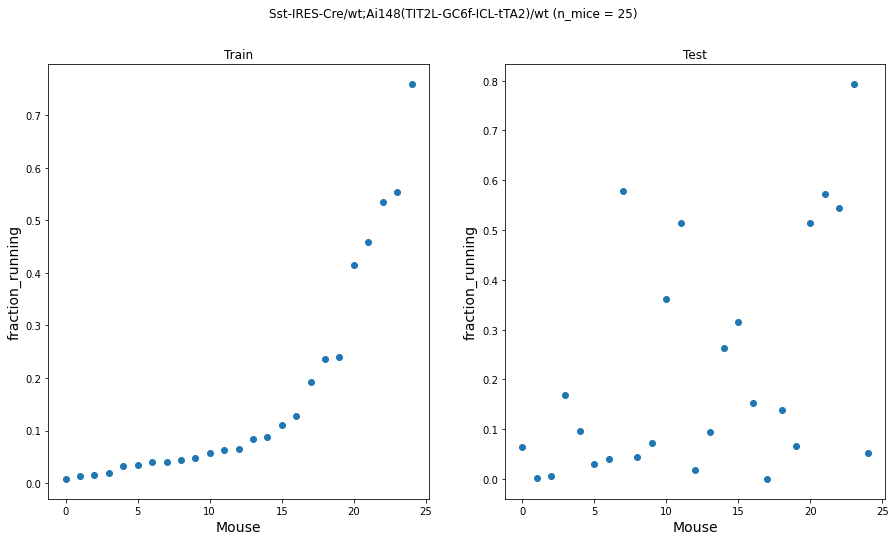

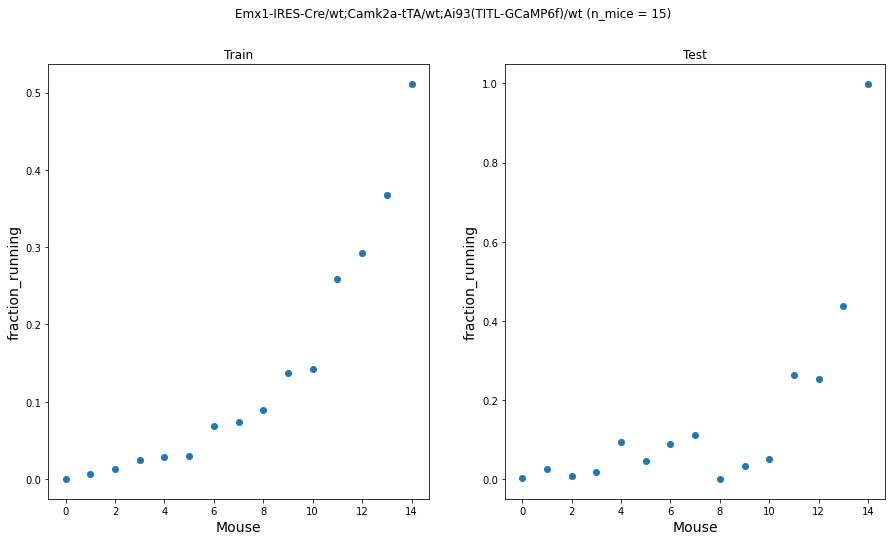

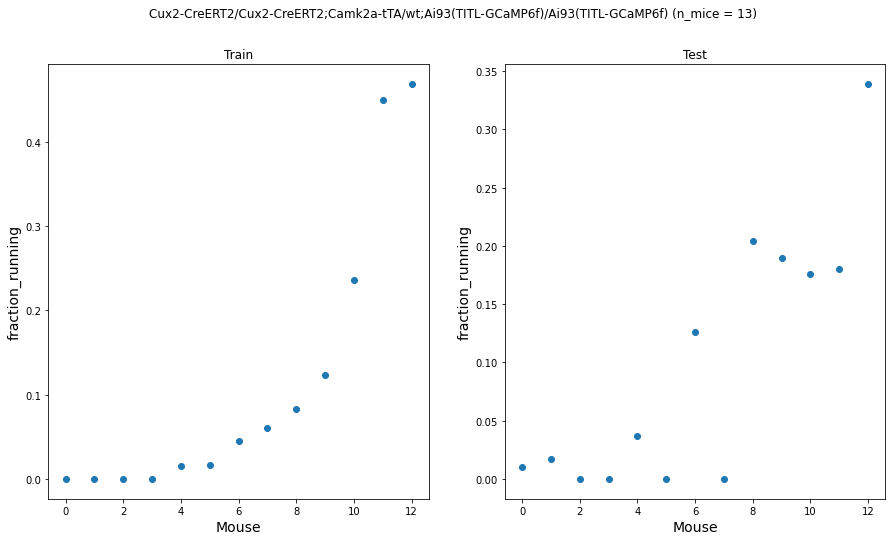

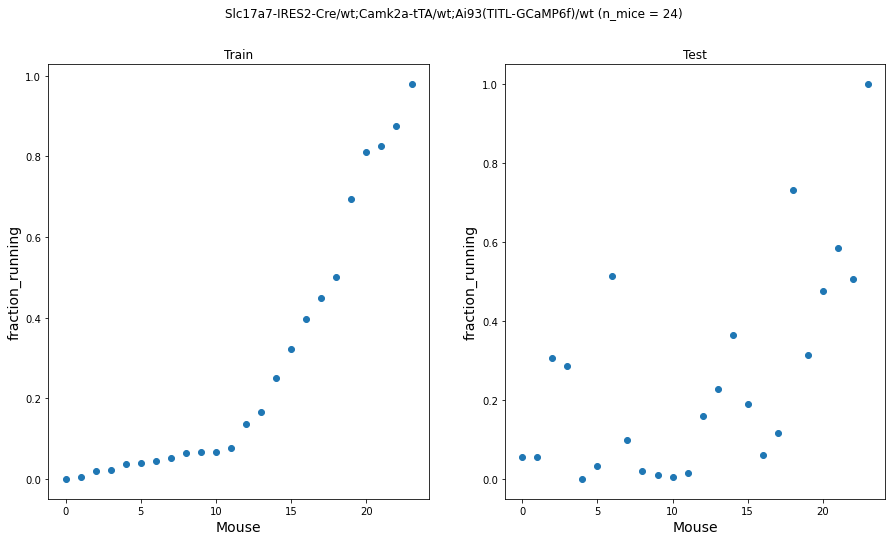

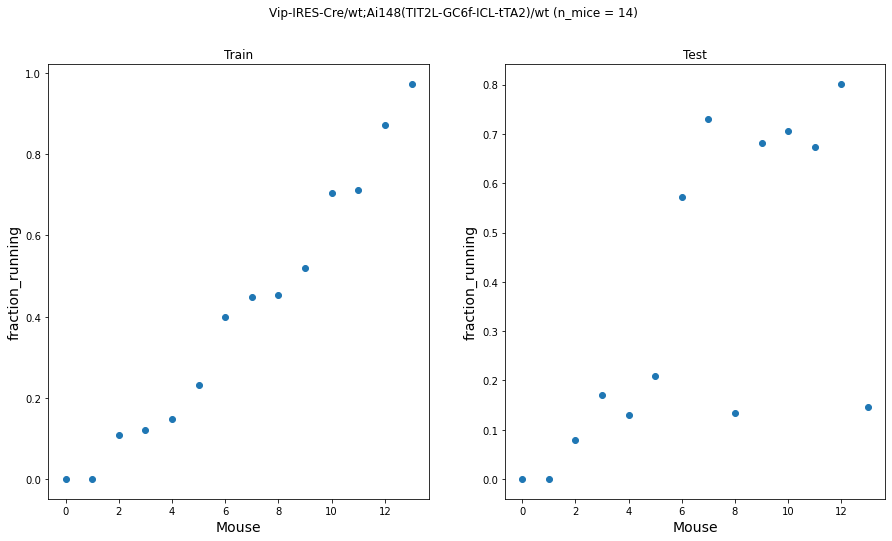

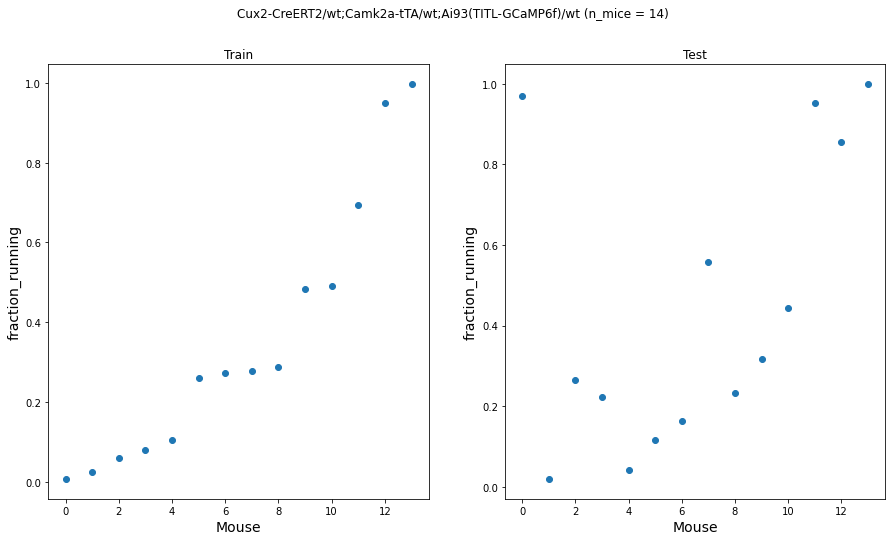

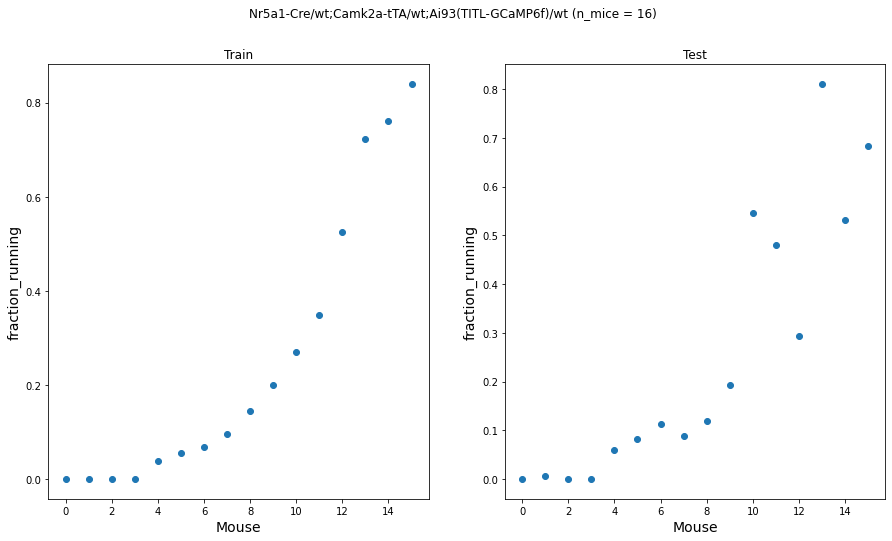

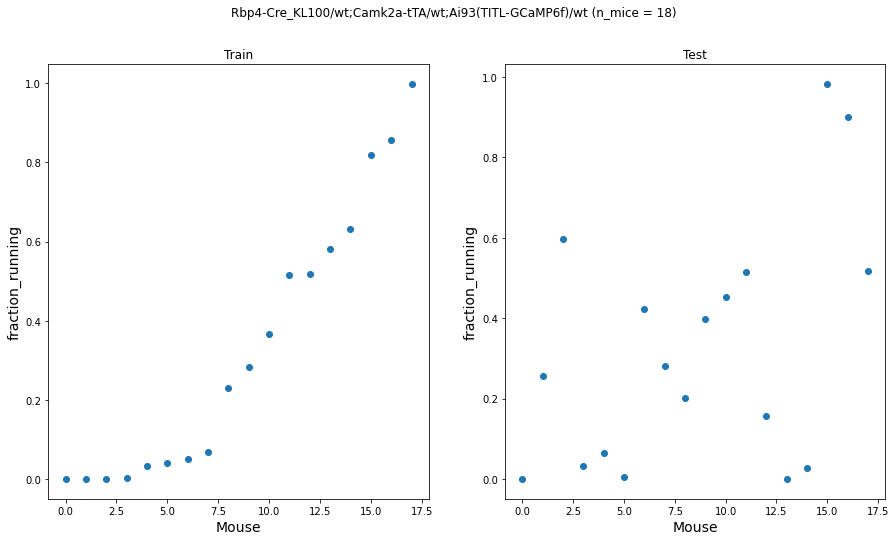

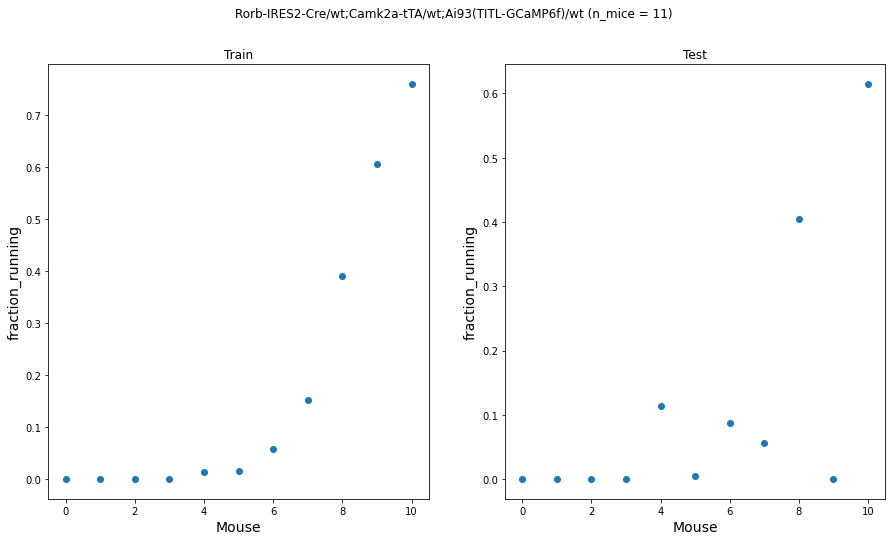

In [75]:
np.random.seed(1)

for genotype in stim_metrics["genotype"].unique():
    df = stim_metrics[stim_metrics["genotype"] == genotype]
    # df = stim_metrics[stim_metrics["genotype"] == "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt"]
    # df = stim_metrics[stim_metrics["genotype"] == "Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt"]
    df = df[df["stimulus"] == "spontaneous"]
    specimen_names = df["specimen_name"].unique()
    n_mice = len(specimen_names)
    metric_train = np.zeros(n_mice)
    metric_test = np.zeros(n_mice)
    metric = "fraction_running"

    if n_mice < 10:
        continue

    for i, specimen_name in enumerate(specimen_names):
        metrics = df[metric][df["specimen_name"] == specimen_name].values

        if len(metrics) < 2:
            continue

        n_train = len(metrics) // 2
        rand_idx = np.random.permutation(len(metrics))

        metric_train[i] = metrics[rand_idx[:n_train]].mean()
        metric_test[i] = metrics[rand_idx[n_train:]].mean()

    sort_idx = np.argsort(metric_train)
    metric_train = metric_train[sort_idx]
    metric_test = metric_test[sort_idx]

    fig, axs = plt.subplots(ncols=2, figsize=(15, 8), facecolor="white")
    x = np.arange(n_mice)
    fig.suptitle(f"{genotype} (n_mice = {n_mice})")
    # sns.scatterplot(x=x, y=metric_train, ax=axs[0])
    axs[0].scatter(x, metric_train)
    axs[0].set_title("Train")
    axs[1].scatter(x, metric_test)
    axs[1].set_title("Test")

    for ax in axs:
        ax.set_xlabel("Mouse", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
